# N-gram Language Model

This notebook demonstrates an implementation and usage of an n-gram language model.
N-gram models extend the bigram model that you (hopefully) learned in lesson one. By considering n-1 previous tokens when predicting
the next token, n-grams allow for more context and better predictions.

## Dataset (Same as bigram)
- For this lesson (and a few others) we will be using a slice of the [arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv). 
- We've collected ~51,000 paper summaries and will be training our n-gram model using this subset.
- The dataset is stored in src/datasets/arxiv_data.csv

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [14]:
# Load the (sliced) ArXiv dataset
dataset = load_dataset(path="../../src/datasets/")

data_str = "\n".join(dataset["train"]["summaries"])

# Split into training and testing sets (90/10 split)
len_train = int(0.9*len(data_str))
train_data = data_str[:len_train]
test_data = data_str[len_train:]

print("\nExample summary:")
print(train_data[:500])


Example summary:
Stereo matching is one of the widely used techniques for inferring depth from
stereo images owing to its robustness and speed. It has become one of the major
topics of research since it finds its applications in autonomous driving,
robotic navigation, 3D reconstruction, and many other fields. Finding pixel
correspondences in non-textured, occluded and reflective areas is the major
challenge in stereo matching. Recent developments have shown that semantic cues
from image segmentation can be used 


## Tokenization

For our character-level n-gram model, we'll tokenize at the character level, assigning a unique integer to each character. See lesson one for more details on tokenization.

In [16]:
# Find all unique characters in our dataset
chars = sorted(list(set(train_data+test_data)))
vocab_size = len(chars)

# Create mapping dictionaries between characters and integers
str_to_i = {ch: i for i, ch in enumerate(chars)}
i_to_str = {i: ch for i, ch in enumerate(chars)}

def encode(s):
    """Convert a string to a list of integers based on our character mapping."""
    return [str_to_i[ch] for ch in s]

def decode(nums):
    """Convert a list of integers back to a string using our character mapping."""
    return ''.join(i_to_str[i] for i in nums)

## Preparing the Data for Training

This is where n-grams start to diverge from bigrams. We'll convert our text data into PyTorch tensors for efficient processing during training.

In [5]:
# Encode the entire dataset into tensors
train_encoded = torch.tensor(encode(train_data), dtype=torch.long)
test_encoded = torch.tensor(encode(test_data), dtype=torch.long)
print("Training data shape:", train_encoded.shape, train_encoded.dtype)
print("First 100 tokens:", train_encoded[:100])

# Define our context window size (block_size)
# For n-grams, block_size should be at least n-1
block_size = 8
print("\nExample context window:", train_encoded[:block_size+1])

Training data shape: torch.Size([56138589]) torch.int64
First 100 tokens: tensor([52, 85, 70, 83, 70, 80,  1, 78, 66, 85, 68, 73, 74, 79, 72,  1, 74, 84,
         1, 80, 79, 70,  1, 80, 71,  1, 85, 73, 70,  1, 88, 74, 69, 70, 77, 90,
         1, 86, 84, 70, 69,  1, 85, 70, 68, 73, 79, 74, 82, 86, 70, 84,  1, 71,
        80, 83,  1, 74, 79, 71, 70, 83, 83, 74, 79, 72,  1, 69, 70, 81, 85, 73,
         1, 71, 83, 80, 78,  0, 84, 85, 70, 83, 70, 80,  1, 74, 78, 66, 72, 70,
        84,  1, 80, 88, 74, 79, 72,  1, 85, 80])

Example context window: tensor([52, 85, 70, 83, 70, 80,  1, 78, 66])


## Creating Training Batches

To train our model efficiently, we'll create batches (groups) of data with inputs and their corresponding targets.
For n-gram models, we need to consider n-1 previous tokens for each prediction.

In [6]:
# Function to generate random batches from our dataset
batch_size = 4  # Number of sequences in a batch
block_size = 8  # Length of each sequence

def get_batch(split):
    """
    Generate a small batch of data for training or evaluation.
    
    Args:
        split: Either 'train' or 'test' to determine which dataset to sample from
        
    Returns:
        x: Input sequences (B, T)
        y: Target sequences (B, T) - shifted by 1 position
    """
    # Choose the appropriate dataset
    data = train_encoded if split == "train" else test_encoded
    
    # Generate random starting indices
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # Extract sequences of length block_size
    x = torch.stack([data[i:i+block_size] for i in ix])
    
    # Target is the next character in the sequence (shifted by 1)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    
    return x, y

# Test our batch generation
xb, yb = get_batch('train')
print("Input batch shape:", xb.shape)
print("Inputs:\n", xb)
print("\nTargets:\n", yb)

# Notice how our target for any input character is the next character in the sequence.

Input batch shape: torch.Size([4, 8])
Inputs:
 tensor([[77, 80, 83, 13,  1, 68, 80, 77],
        [87, 70, 83, 84, 74, 71, 74, 70],
        [79, 84, 81, 80, 83, 85,  1, 68],
        [68, 66, 77,  0, 80, 87, 70, 83]])

Targets:
 tensor([[80, 83, 13,  1, 68, 80, 77, 80],
        [70, 83, 84, 74, 71, 74, 70, 69],
        [84, 81, 80, 83, 85,  1, 68, 80],
        [66, 77,  0, 80, 87, 70, 83, 71]])


## N-gram Language Model Implementation

Now we'll implement our n-gram language model. This model predicts the next character based on the previous n-1 characters.
This is an extension of the bigram model (where n=2) to consider more context.

In [7]:
class NgramLanguageModel:
    def __init__(self, vocab_size, n=3, alpha=0.1):
        """
        Initialize the n-gram language model.
        
        Args:
            vocab_size: Size of the vocabulary (number of unique characters)
            n: The 'n' in n-gram (default: 3 for trigram - we will explore higher n-grams)
            alpha: Smoothing parameter for Laplace smoothing (default: 0.1)
        """
        self.vocab_size = vocab_size
        self.n = n
        self.alpha = alpha  # Smoothing parameter
        
        # For neural network approach
        # We'll use an embedding table to represent the n-gram context
        # The size depends on n: for n=3, we need to embed 2 previous tokens
        self.context_size = n - 1
        
        # Create embedding tables for each position in the context
        self.token_embedding_tables = [
            torch.randn((vocab_size, vocab_size), requires_grad=True)
            for _ in range(self.context_size)
        ]
        
        # Create a linear layer to combine the embeddings
        self.output_layer = torch.randn((self.context_size * vocab_size, vocab_size), requires_grad=True)
        
        # For count-based approach (used for visualization and analysis)
        self.ngram_counts = defaultdict(Counter)
        self.context_counts = defaultdict(int)
        self.is_trained_count_based = False
    
    def train_count_based(self, data):
        """
        Train the count-based n-gram model by counting occurrences in the data.
        
        Args:
            data: Tensor of token indices
        """
        # Convert tensor to list for easier processing
        tokens = data.tolist()
        
        # Count n-grams
        for i in range(len(tokens) - self.n + 1):
            # Extract the n-gram
            ngram = tuple(tokens[i:i+self.n])
            
            # The context is the first n-1 tokens
            context = ngram[:-1]
            # The target is the last token
            target = ngram[-1]
            
            # Update counts
            self.ngram_counts[context][target] += 1
            self.context_counts[context] += 1
        
        self.is_trained_count_based = True
        
    def get_smoothed_probability(self, context, target):
        """
        Get the smoothed probability of a target given a context using Laplace smoothing.
        
        Args:
            context: Tuple of context tokens
            target: Target token
            
        Returns:
            probability: Smoothed probability P(target|context)
        """
        # Count of this specific n-gram
        count = self.ngram_counts[context][target]
        
        # Count of the context
        context_count = self.context_counts[context]
        
        # Apply Laplace smoothing: (count + alpha) / (context_count + alpha * vocab_size)
        probability = (count + self.alpha) / (context_count + self.alpha * self.vocab_size)
        
        return probability
    
    def forward(self, idx):
        """
        Forward pass of the neural n-gram model.
        
        Args:
            idx: Batch of sequences (B, T)
            
        Returns:
            logits: Prediction scores for next character (B, T, C)
        """
        B, T = idx.shape
        
        # Initialize output tensor
        logits = torch.zeros((B, T, self.vocab_size))
        
        # For each position in the sequence
        for t in range(T):
            # For each position in the context
            context_vectors = []
            
            for c in range(self.context_size):
                # Get the token at this context position, handling boundary conditions
                if t - self.context_size + c < 0:
                    # If we're at the beginning, use padding (token 0)
                    token_idx = torch.zeros((B,), dtype=torch.long)
                else:
                    token_idx = idx[:, t - self.context_size + c]
                
                # Look up the embedding for this token at this context position
                context_vector = self.token_embedding_tables[c][token_idx]  # (B, C)
                context_vectors.append(context_vector)
            
            # Concatenate all context vectors
            combined_context = torch.cat(context_vectors, dim=1)  # (B, context_size*C)
            
            # Compute logits for this position
            position_logits = combined_context @ self.output_layer  # (B, C)
            logits[:, t] = position_logits
        
        return logits
    
    def parameters(self):
        """Return the parameters of the model for optimization."""
        params = self.token_embedding_tables.copy()
        params.append(self.output_layer)
        return params
    
    def generate(self, idx, max_new_tokens, temperature=1.0):
        """
        Generate new text by sampling from the model's predictions.
        
        Args:
            idx: Starting sequence (B, T)
            max_new_tokens: Number of new tokens to generate
            temperature: Controls randomness in sampling (higher = more random)
            
        Returns:
            idx: Extended sequence with generated tokens (B, T+max_new_tokens)
        """
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Get the predictions
            logits = self.forward(idx)  # (B, T, C)
            
            # Focus only on the last time step
            logits = logits[:, -1, :]  # (B, C)
            
            # Apply temperature scaling
            logits = logits / temperature
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
            
        return idx
    
    def generate_count_based(self, context=None, max_new_tokens=100, temperature=1.0):
        """
        Generate text using the count-based n-gram model.
        
        Args:
            context: Initial context (list of tokens)
            max_new_tokens: Number of tokens to generate
            temperature: Controls randomness (higher = more random)
            
        Returns:
            generated_text: List of generated token indices
        """
        if not self.is_trained_count_based:
            raise ValueError("Count-based model has not been trained yet")
        
        # Initialize with empty context if none provided
        if context is None:
            # Start with a random context from the training data
            context_keys = list(self.context_counts.keys())
            if context_keys:
                context = list(context_keys[np.random.randint(len(context_keys))])
            else:
                # If no contexts available, start with zeros
                context = [0] * (self.n - 1)
        
        # Ensure context is the right length
        context = context[-(self.n-1):]
        
        # Initialize generated text with the context
        generated_text = list(context)
        
        # Generate new tokens
        for _ in range(max_new_tokens):
            # Get the current context
            current_context = tuple(generated_text[-(self.n-1):])
            
            # If this context has never been seen, back off to a shorter context or random
            if current_context not in self.context_counts:
                # Try backing off to a shorter context
                found_context = False
                for backoff_length in range(self.n-2, 0, -1):
                    shorter_context = current_context[-backoff_length:]
                    if shorter_context in self.context_counts:
                        current_context = shorter_context
                        found_context = True
                        break
                
                # If no context found, choose randomly
                if not found_context:
                    next_token = np.random.randint(self.vocab_size)
                    generated_text.append(next_token)
                    continue
            
            # Get probabilities for all possible next tokens
            probs = np.zeros(self.vocab_size)
            for token in range(self.vocab_size):
                probs[token] = self.get_smoothed_probability(current_context, token)
            
            # Apply temperature
            probs = np.power(probs, 1.0/temperature)
            probs = probs / np.sum(probs)  # Renormalize
            
            # Sample from the distribution
            next_token = np.random.choice(self.vocab_size, p=probs)
            generated_text.append(next_token)
        
        return generated_text
    
    def perplexity(self, data):
        """
        Calculate the perplexity of the model on the given data.
        Perplexity is a measure of how well the model predicts the data.
        Lower perplexity is better.
        
        Args:
            data: Tensor of token indices
            
        Returns:
            perplexity: Perplexity score
        """
        if not self.is_trained_count_based:
            raise ValueError("Count-based model has not been trained yet")
        
        # Convert tensor to list
        tokens = data.tolist()
        
        # Calculate log probability of the data
        log_prob = 0.0
        count = 0
        
        for i in range(self.n-1, len(tokens)):
            # Get the context
            context = tuple(tokens[i-(self.n-1):i])
            # Get the target
            target = tokens[i]
            
            # Get probability
            prob = self.get_smoothed_probability(context, target)
            
            # Add log probability
            log_prob += np.log2(prob)
            count += 1
        
        # Calculate average log probability
        avg_log_prob = log_prob / count
        
        # Perplexity is 2^(-avg_log_prob)
        perplexity = 2 ** (-avg_log_prob)
        
        return perplexity

Important concepts: perplexity, smoothing and sparsity |
![Perplexity](assets/perplexity_visualization.png)
![Smoothing](assets/smoothing_visualization.png)
![Sparsity](assets/ngram_sparsity_visualization.png)

## Training the Model

We'll define our loss function and training loop to optimize the model's parameters.

In [8]:
# Choose the n for our n-gram model
n = 3  # Trigram model
model = NgramLanguageModel(vocab_size, n=n)

# Test the model's forward pass
xb, yb = get_batch('train')
logits = model.forward(xb)
print(f"Input shape: {xb.shape}")
print(f"Output logits shape: {logits.shape}")

def loss_fn(logits, targets):
    """
    Calculate the cross-entropy loss between predictions and targets.
    
    Args:
        logits: Prediction scores (B, T, C)
        targets: Target indices (B, T)
        
    Returns:
        loss: Scalar loss value
    """
    B, T, C = logits.shape
    logits = logits.view(B*T, C)  # Reshape for cross_entropy
    targets = targets.view(B*T)   # Reshape to match
    loss = F.cross_entropy(logits, targets)
    return loss

# Calculate initial loss
loss = loss_fn(logits, yb)
print(f"Initial loss: {loss.item()}")

# Generate some text before training
idx = torch.zeros((1, 1), dtype=torch.long)
print("\nText generated before training:")
generated_text = model.generate(idx, max_new_tokens=100)[0]
print(decode(generated_text.tolist()))

Input shape: torch.Size([4, 8])
Output logits shape: torch.Size([4, 8, 98])
Initial loss: 36.62493896484375

Text generated before training:

uuK7=k|)pdammZmmgmmZmmgmmVmmtmmZmmgmmtmmgmmZmm7mTtmSgmoZmhgm]tm@gmktmpZNVKOYk1h:”];3k~<sRP(kx1$:”s;3


## Training Loop

Now we'll train our neural n-gram model by repeatedly sampling batches and updating the parameters.

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def train(model, epochs=10000, eval_interval=1000):
    """
    Train the n-gram language model.
    
    Args:
        model: The NgramLanguageModel instance
        epochs: Number of training iterations
        eval_interval: How often to evaluate and print progress
    """
    for i in range(epochs):
        # Sample a batch of data
        xb, yb = get_batch('train')
        
        # Evaluate the loss
        logits = model.forward(xb)
        loss = loss_fn(logits, yb)
        
        # Zero gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        
        if i % eval_interval == 0:
            print(f"Step {i}: Loss {loss.item():.4f}")
            
            # Generate some text
            if i % (eval_interval * 10) == 0:
                idx = torch.zeros((1, 1), dtype=torch.long)
                generated = model.generate(idx, max_new_tokens=100)[0]
                print(decode(generated.tolist()))
                print('-' * 80)

print("Training the neural n-gram model...")
train(model, epochs=20000, eval_interval=1000)

Training the neural n-gram model...
Step 0: Loss 35.6607

uuK7=k|)pdammZmmgmmZmm7mTtmSgmotm”g[[S_SS<SE:t>F@Dyi@cS”DE{@LD&f@Xg)hVa_*l<Y"Y$YS)SoamyZmcgm`tm|gm[Z
--------------------------------------------------------------------------------
Step 1000: Loss 6.3778
Step 2000: Loss 5.2512
Step 3000: Loss 4.7738
Step 4000: Loss 3.3275
Step 5000: Loss 2.8688
Step 6000: Loss 2.8242
Step 7000: Loss 2.8076
Step 8000: Loss 2.9279
Step 9000: Loss 2.6156
Step 10000: Loss 2.8309

sov lygiaggtnginn.w.r tor  eo estue, wf ohn  hnsodntitio  Mpvyl vrr dbqtaN -epd.fTientwoieitlericati
--------------------------------------------------------------------------------
Step 11000: Loss 3.2493
Step 12000: Loss 2.8909
Step 13000: Loss 3.2236
Step 14000: Loss 2.5355
Step 15000: Loss 3.5834
Step 16000: Loss 2.9481
Step 17000: Loss 3.5897
Step 18000: Loss 2.7638
Step 19000: Loss 3.0824


## Count-Based N-gram Model

In addition to our neural n-gram model, let's also train a traditional count-based n-gram model
with Laplace smoothing for comparison.

In [10]:
# Train the count-based model
count_model = NgramLanguageModel(vocab_size, n=n)
print("Training the count-based n-gram model...")
count_model.train_count_based(train_encoded)

# Calculate perplexity on test data
test_perplexity = count_model.perplexity(test_encoded)
print(f"Test perplexity: {test_perplexity:.2f}")

# Generate text with the count-based model
print("\nGenerating text with the count-based model:")
generated_indices = count_model.generate_count_based(max_new_tokens=100)
print(decode(generated_indices))

Training the count-based n-gram model...
Test perplexity: 6.99

Generating text with the count-based model:
vz|x). In the inetwor GANs. A hattisper a vis onvol datice esting to arthe agenconlayerfaing and Dific


## Visualizing N-gram Probabilities

Let's visualize the probabilities of some common n-grams to understand what the model has learned.

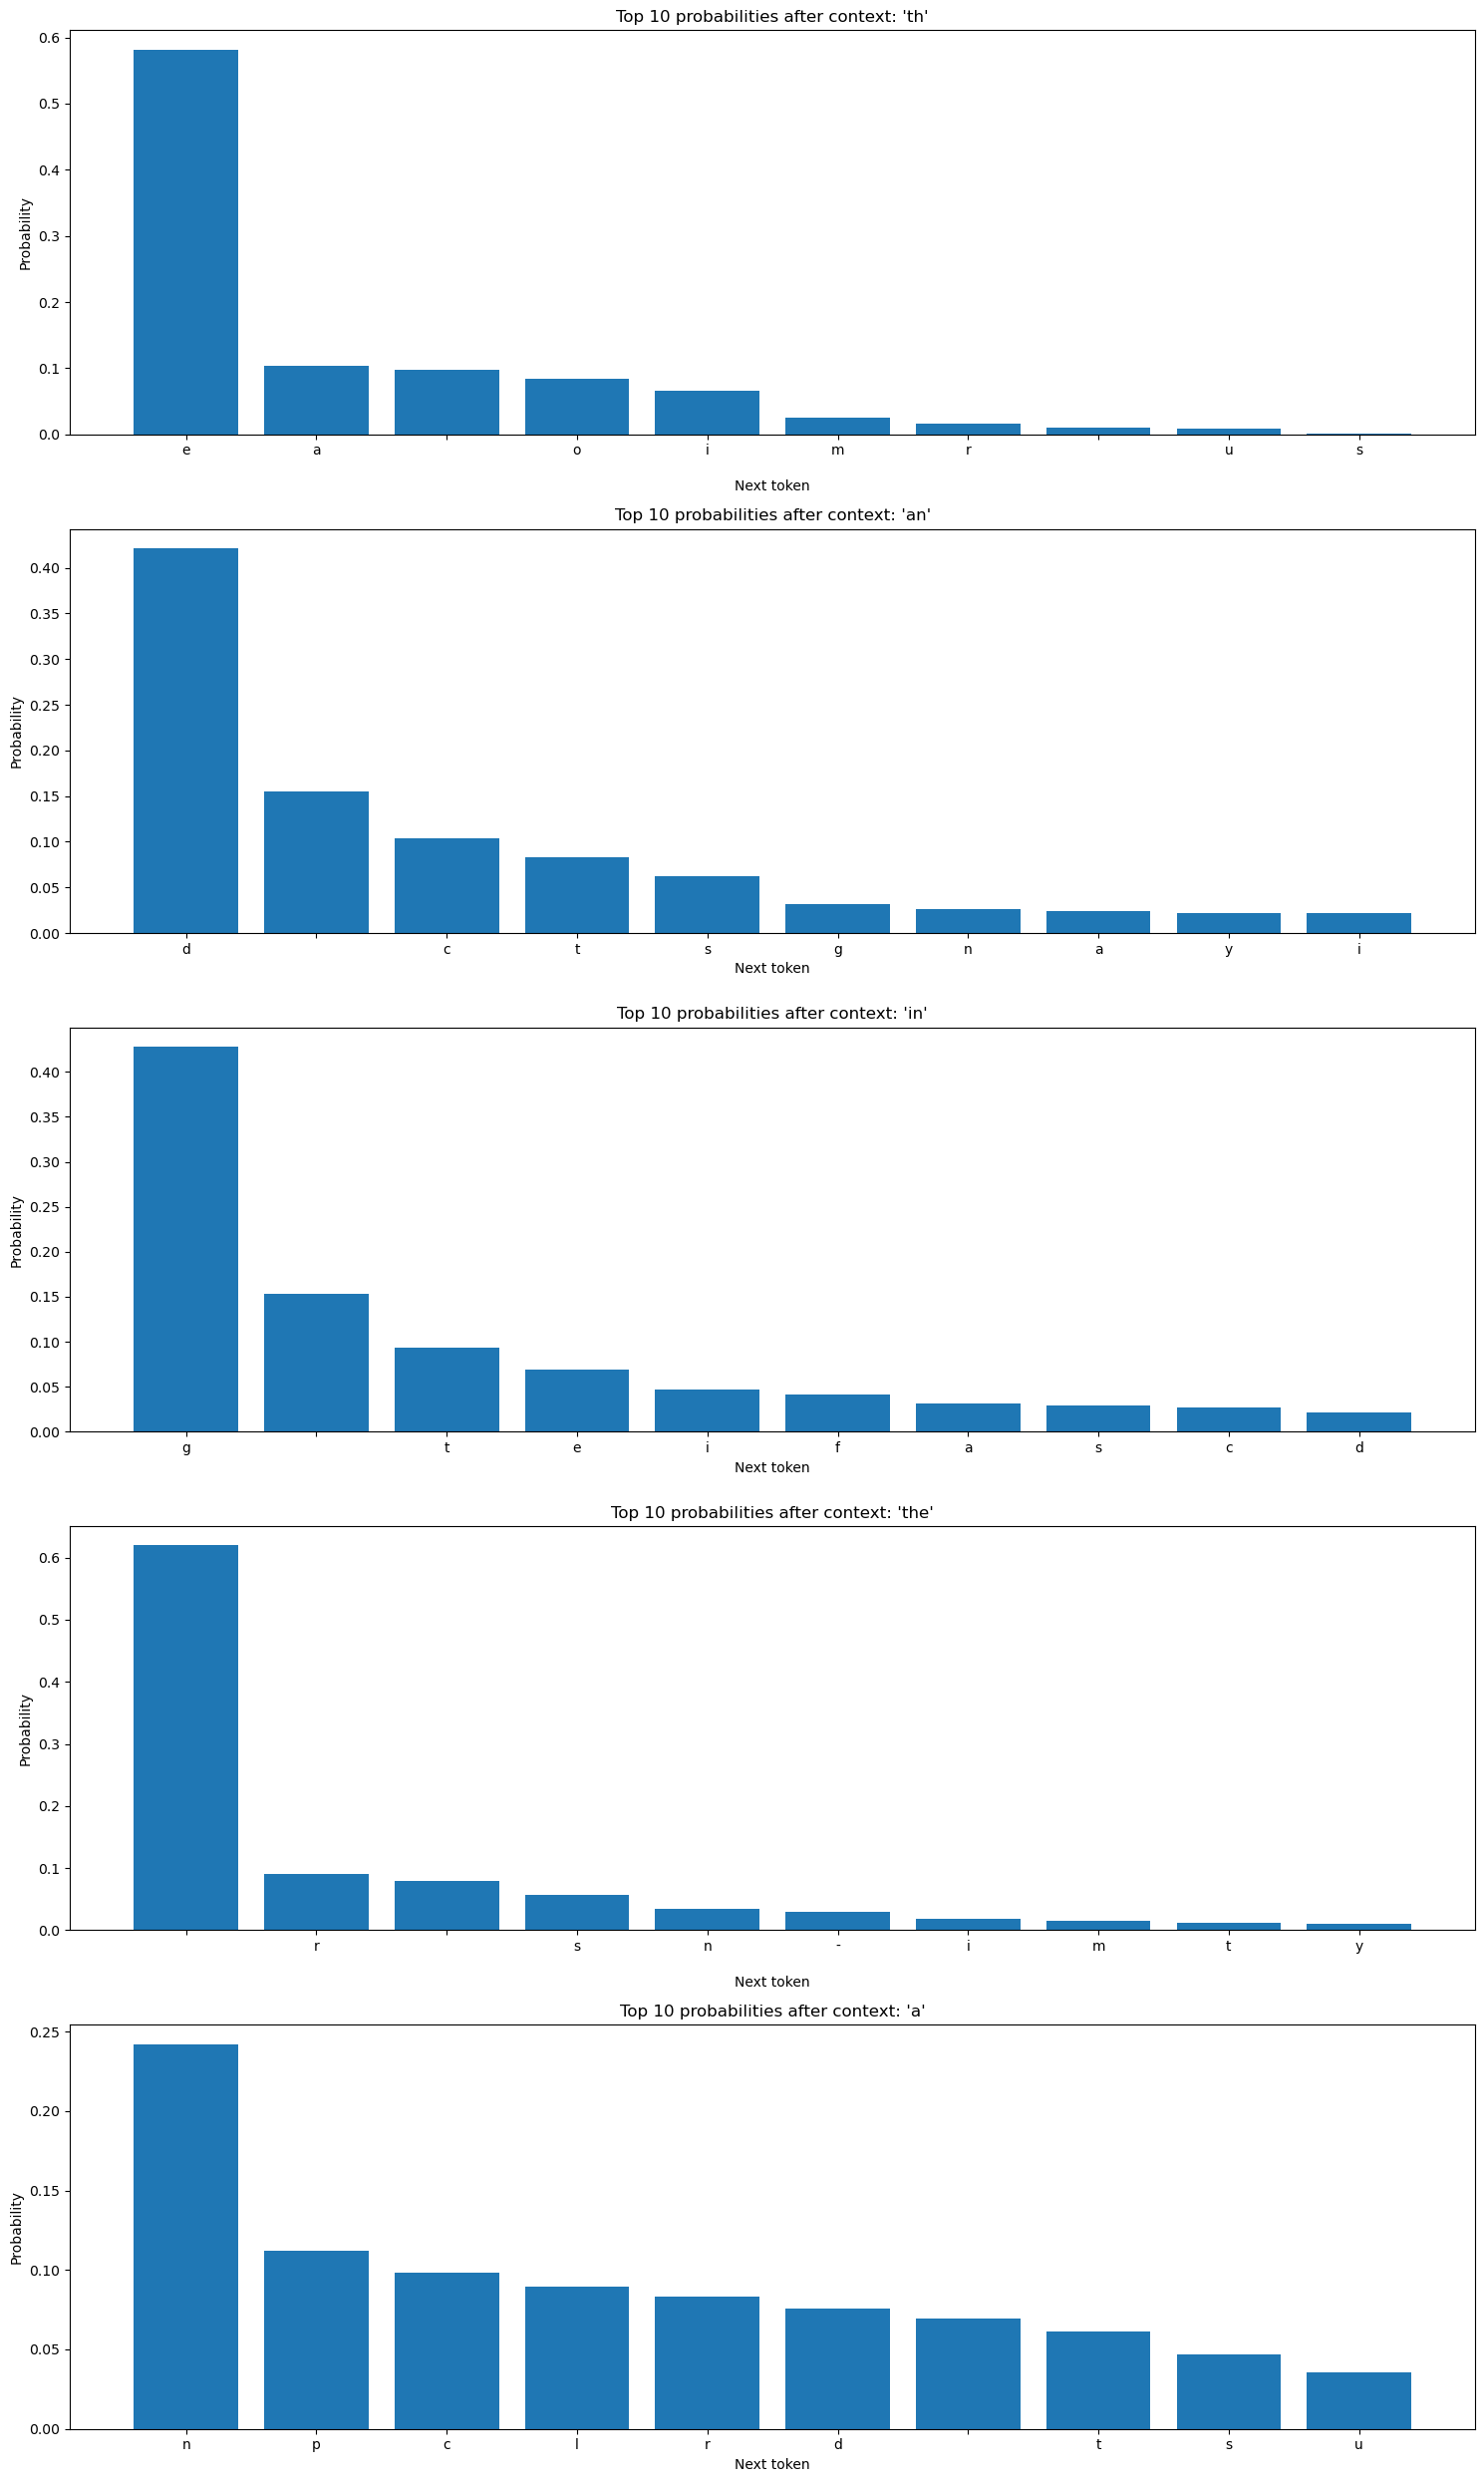

In [11]:
def visualize_ngram_probabilities(model, contexts, top_n=10):
    """
    Visualize the probabilities of the top N next tokens for given contexts.
    
    Args:
        model: Trained NgramLanguageModel
        contexts: List of context strings to visualize
        top_n: Number of top probabilities to show
    """
    plt.figure(figsize=(15, 5 * len(contexts)))
    
    for i, context_str in enumerate(contexts):
        # Encode the context
        context = encode(context_str)
        
        # Ensure context is the right length
        if len(context) > model.n - 1:
            context = context[-(model.n-1):]
        elif len(context) < model.n - 1:
            # Pad with zeros if needed
            context = [0] * (model.n - 1 - len(context)) + context
        
        context_tuple = tuple(context)
        
        # Get probabilities for all tokens
        probs = [(token, model.get_smoothed_probability(context_tuple, token)) 
                 for token in range(model.vocab_size)]
        
        # Sort by probability
        probs.sort(key=lambda x: x[1], reverse=True)
        
        # Take top N
        top_probs = probs[:top_n]
        
        # Plot
        plt.subplot(len(contexts), 1, i+1)
        tokens = [decode([token]) for token, _ in top_probs]
        probabilities = [prob for _, prob in top_probs]
        
        plt.bar(tokens, probabilities)
        plt.title(f"Top {top_n} probabilities after context: '{context_str}'")
        plt.xlabel("Next token")
        plt.ylabel("Probability")
    
    plt.tight_layout()
    plt.show()

# Visualize some common contexts
contexts = ["th", "an", "in", "the", "a"]
visualize_ngram_probabilities(count_model, contexts)

## Comparing Different Values of N

Let's compare the performance of n-gram models with different values of n.

Training 2-gram model...
2-gram model perplexity: 12.17
Sample from 2-gram model:
{bis w mals sed
merowiomind artil se rageng ctimit 
--------------------------------------------------------------------------------
Training 3-gram model...
3-gram model perplexity: 6.99
Sample from 3-gram model:
4\%$ (MARL of mon mon of hants gresence the
vissimpr
--------------------------------------------------------------------------------
Training 4-gram model...
4-gram model perplexity: 4.22
Sample from 4-gram model:
OAT artifical of introntion. Third
ass in of the each
--------------------------------------------------------------------------------
Training 5-gram model...
5-gram model perplexity: 3.27
Sample from 5-gram model:
n HNs)sg9h>PG"bDeB5EZ/H“jKV2{<=lK!xun }l`A|\GxIxH`N~sP
--------------------------------------------------------------------------------


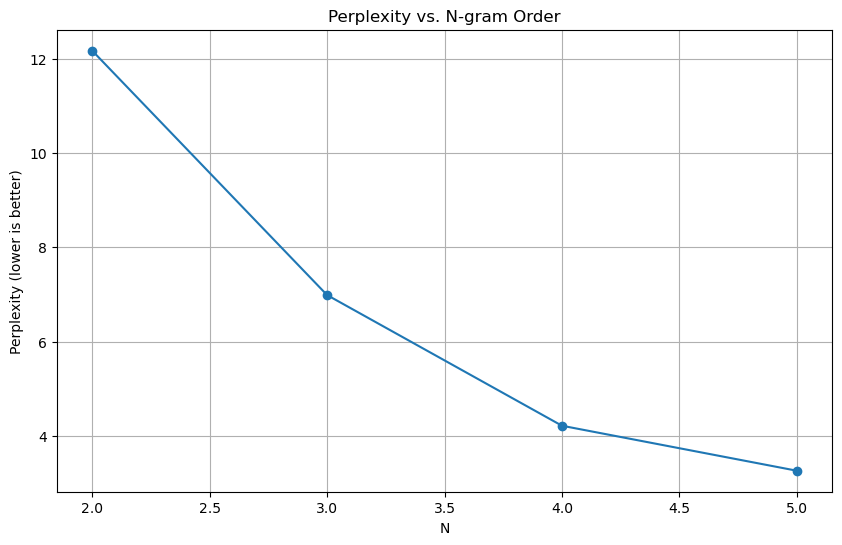

In [12]:
def compare_ngram_models(n_values, test_data):
    """
    Compare n-gram models with different values of n.
    
    Args:
        n_values: List of n values to compare
        test_data: Test data tensor
    
    Returns:
        perplexities: Dictionary mapping n to perplexity
    """
    perplexities = {}
    
    for n in n_values:
        print(f"Training {n}-gram model...")
        model = NgramLanguageModel(vocab_size, n=n)
        model.train_count_based(train_encoded)
        
        perplexity = model.perplexity(test_data)
        perplexities[n] = perplexity
        print(f"{n}-gram model perplexity: {perplexity:.2f}")
        
        # Generate a sample
        generated = model.generate_count_based(max_new_tokens=50)
        print(f"Sample from {n}-gram model:")
        print(decode(generated))
        print("-" * 80)
    
    return perplexities

# Compare models with different n values
n_values = [2, 3, 4, 5]
perplexities = compare_ngram_models(n_values, test_encoded)

# Plot perplexities
plt.figure(figsize=(10, 6))
plt.plot(list(perplexities.keys()), list(perplexities.values()), marker='o')
plt.title("Perplexity vs. N-gram Order")
plt.xlabel("N")
plt.ylabel("Perplexity (lower is better)")
plt.grid(True)
plt.show()

## Generating Text with the Trained Model

Let's generate a longer piece of text with our trained neural n-gram model to see what it has learned.

In [13]:
# Generate a longer text sample with the neural model
print("\nGenerating text with the trained neural n-gram model:")
idx = torch.zeros((1, 1), dtype=torch.long)
generated_text = model.generate(idx, max_new_tokens=500, temperature=0.8)[0]
print(decode(generated_text.tolist()))

# Generate text with the count-based model
print("\n\nGenerating text with the count-based n-gram model:")
generated_indices = count_model.generate_count_based(max_new_tokens=500, temperature=0.8)
print(decode(generated_indices))

# Generate text with a random model for comparison
print("\n\nGenerating text with a random model for comparison:")
random_model = NgramLanguageModel(vocab_size, n=n)
idx = torch.zeros((1, 1), dtype=torch.long)
random_generated_text = random_model.generate(idx, max_new_tokens=500)[0]
print(decode(random_generated_text.tolist()))


Generating text with the trained neural n-gram model:

seaoi  aensiv rsmpdep rtd f chetsaek  oeotgatceite de sconluaeien iinawetdehc pnafiot kettea aol aiegsingdresa( .aSi cdmogedcllnrr mctroen
 patt kttoekdnmare dfmrdnmwgtea eov lis nnawd dpsriinner  nNwtremener.aTe  sonmancrupeor  rappteaahe ens
n  rea ar ar  uoe sad madef rrcarn i det oidnlidrpasceateag tna  ias  nurh.wBeki i   ae fba niag  tmaddon srfbrxmmnueee ceatndflemeltoiks   eld-aeaet er ab troirtlnc nnariiglaie def.eW" ti essaai a  oa iot  roapiri uien  eo  taee  epdinn  xaeiiea eiti neqt


Generating text with the count-based n-gram model:
g\> 10, ouneirell Nethe her,
se nons frork ficalution a hitionetion terialgor algor of gaing ne of beeptionally uperaterated se proble
und the sese tralicarning symbelaing the th an the ing actionvoxeciffeal arized ther of
ovele. In arning ans
cont
ater truch arearegmently laccultion proveng a nels,
SR. Innon Grationly a gentable
typer ind beensizable de to joicated volle lares trund on


## Conclusion

Congratulations! You've now implemented and trained an n-gram language model, which extends the bigram model by considering more context tokens.

Key improvements over the bigram model:
1. More context - considers n-1 previous tokens instead of just 1
2. Smoothing techniques - handles unseen n-grams more gracefully
3. Better text generation - produces more coherent sequences

Key limitations that still remain:
1. Limited context window - still can't capture very long-range dependencies
2. Sparsity issues - higher-order n-grams are often not observed in training data
3. Memory requirements - storing counts for all possible n-grams becomes prohibitive as n increases

In the next lessons, we'll explore more sophisticated models like word embeddings and neural networks that can overcome these limitations.

## Exercises

1. **Experiment with different values of n**: Try different values of n and observe how they affect the model's performance and generated text.

2. **Implement different smoothing techniques**: Try implementing other smoothing methods like Good-Turing or Kneser-Ney smoothing and compare their performance.

3. **Implement backoff n-grams**: Modify the model to use shorter contexts when longer ones aren't available in the training data.

4. **Compare character-level vs. word-level n-grams**: Modify the code to work with words instead of characters and compare the results.

5. **Analyze perplexity vs. n**: Conduct a more thorough analysis of how perplexity changes with different values of n and different amounts of training data.